In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [4]:


pathto = "../../data/raw/VERO/"
cell_list = ["cell1","cell2","cell3","cell4","cell5","cell6"]
dataframe = dict()

for cell in cell_list:

    with Image.open(pathto + cell + '/mpx.tif') as img:
        # Create a list to hold each frame as a NumPy array
        frames = []
        # Iterate over each frame
        for frame in range(img.n_frames):
            img.seek(frame)
            # Append the frame to the list
            frames.append(np.array(img))
    
        # Stack all frames into a single 3D NumPy array
        original = np.stack(frames)
    dataframe[cell] = dict()
    dataframe[cell]["original"] = original


In [23]:

pathto = "../../figures/VERO/cells/"
cell_list = ["cell1","cell2","cell3","cell4","cell5","cell6"]
nice_images = dict()

for cell in cell_list:
    nice_images[cell] = np.transpose(np.array(Image.open(pathto + cell + '.jpg')),(2, 0, 1))



In [24]:
nice_images["cell1"].shape

(3, 703, 548)

In [25]:
channels = dataframe["cell1"]["original"].shape[0]

In [26]:
colors = ["red","orange","green","blue","pink","purple"]

In [33]:
def stitch(big_matrix,small_matrix,x0,y0):
    big_matrix[:,y0:y0+small_matrix.shape[1], x0:x0+small_matrix.shape[2]] = small_matrix
    return big_matrix
def bounding_box(small_matrix,x0,y0,margin):
    width = small_matrix.shape[2]
    height = small_matrix.shape[1]
    left = x0 - margin
    right = x0 + width + margin
    bot = y0 - margin
    top = y0 + height + margin

    xs = [left,left,right,right,left]
    ys = [bot,top,top, bot,bot]

    return xs, ys
    
full = np.zeros((channels,1700,2800))
full_nice = np.zeros((3,1700,2800))


shift1 = {"x": 150, "y" :150}
full = stitch(full,dataframe["cell1"]["original"],shift1["x"],shift1["y"])
box1 = bounding_box(dataframe["cell1"]["original"],shift1["x"],shift1["y"],100) 
full_nice = stitch(full_nice,nice_images["cell1"],shift1["x"],shift1["y"])

shift2 = {"x": 150, "y" :1150}
full = stitch(full,dataframe["cell2"]["original"],shift2["x"],shift2["y"])
box2 = bounding_box(dataframe["cell2"]["original"],shift2["x"],shift2["y"],100) 
full_nice = stitch(full_nice,nice_images["cell2"],shift2["x"],shift2["y"])


shift3 = {"x": 1200, "y" :1000}
full = stitch(full,dataframe["cell3"]["original"],shift3["x"],shift3["y"])
box3 = bounding_box(dataframe["cell3"]["original"],shift3["x"],shift3["y"],100) 
full_nice = stitch(full_nice,nice_images["cell3"],shift3["x"],shift3["y"])


shift4 = {"x": 1200, "y" :150}
full = stitch(full,dataframe["cell4"]["original"],shift4["x"],shift4["y"])
box4 = bounding_box(dataframe["cell4"]["original"],shift4["x"],shift4["y"],100) 
full_nice = stitch(full_nice,nice_images["cell4"],shift4["x"],shift4["y"])


shift5 = {"x": 2070, "y" :1000}
full = stitch(full,dataframe["cell5"]["original"],shift5["x"],shift5["y"])
box5 = bounding_box(dataframe["cell5"]["original"],shift5["x"],shift5["y"],100) 
full_nice = stitch(full_nice,nice_images["cell5"],shift5["x"],shift5["y"])


shift6 = {"x": 2000, "y" :150}
full = stitch(full,dataframe["cell6"]["original"],shift6["x"],shift6["y"])
box6 = bounding_box(dataframe["cell6"]["original"],shift6["x"],shift6["y"],100) 
full_nice = stitch(full_nice,nice_images["cell6"],shift6["x"],shift6["y"])



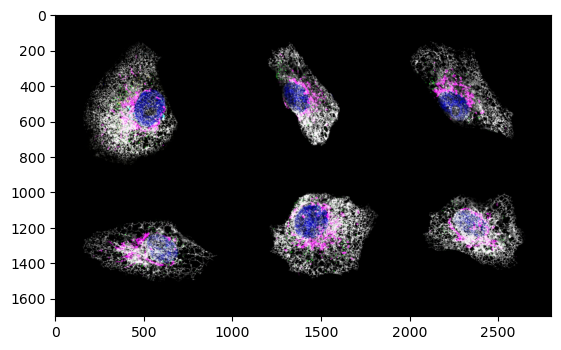

In [35]:
boxes= [box1,box2,box3,box4,box5,box6]

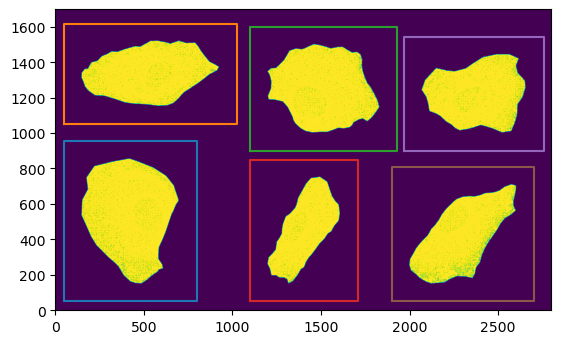

In [36]:
plt.imshow(full[1]>0,origin = "lower")
plt.plot(box1[0],box1[1])
plt.plot(box2[0],box2[1])
plt.plot(box3[0],box3[1])
plt.plot(box4[0],box4[1])
plt.plot(box5[0],box5[1])
plt.plot(box6[0],box6[1])

In [37]:
nucleus = full[0]
lipid = full[1]
peroxisomes = full[2]
mitochondria = full[3]
golgi = full[4]
er = full[5]
nucleus2 = full[6]
scale = 10.8557 #px/um

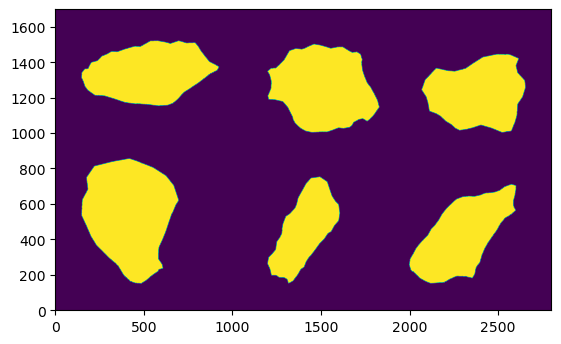

In [38]:
# Nucleus MASK
from scipy import ndimage
from scipy.ndimage import distance_transform_edt
from skimage.morphology import closing,opening, disk
from skimage.morphology import remove_small_objects


cells_mask =closing(nucleus>0,disk(5))
plt.imshow(cells_mask,origin = "lower")

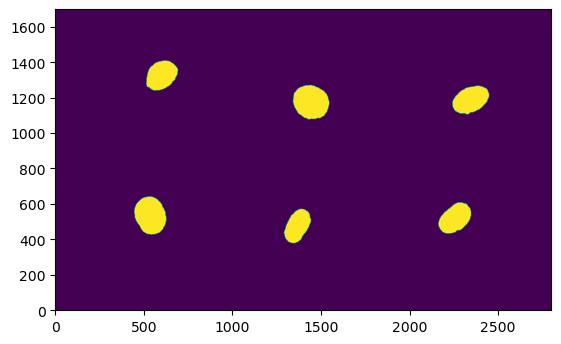

In [39]:
nucleus_mask = nucleus > 10
nucleus_mask = ndimage.binary_fill_holes(nucleus_mask)
nucleus_mask = remove_small_objects(nucleus_mask,100)
nucleus_mask = closing(nucleus_mask, disk(10))
nucleus_mask = opening(nucleus_mask, disk(10))

plt.imshow(nucleus_mask,origin = "lower")


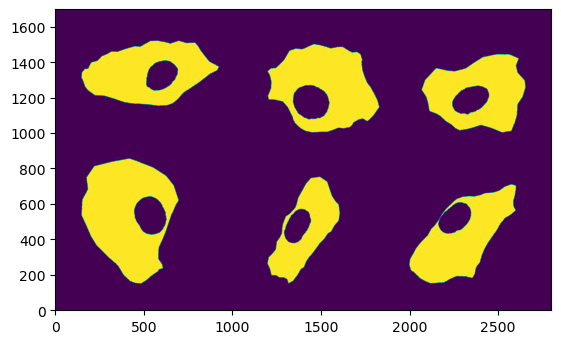

In [41]:
domains_mask = cells_mask & ~ nucleus_mask
plt.imshow(domains_mask,origin = "lower")

#SETUP BINARIES #



Text(0.5, 1.0, 'golgi')

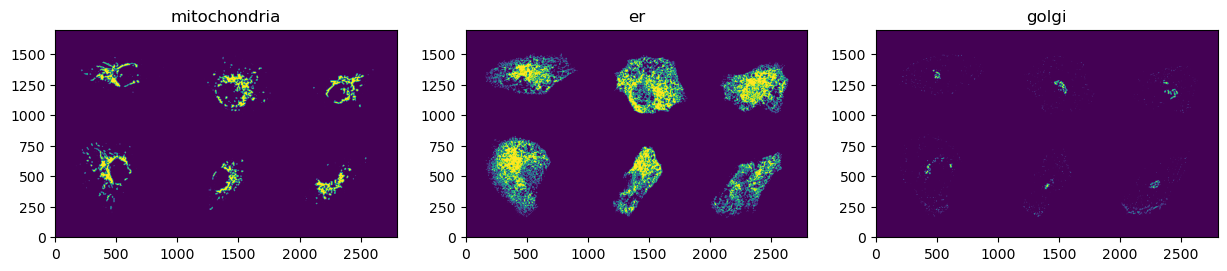

In [42]:

# Plot each dataset on its corresponding subplot




mitochondria_mask = mitochondria > 80

er_mask = er > 1500

golgi_mask = golgi > 50


fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

axs[0].imshow(mitochondria_mask,origin = "lower")
axs[0].set_title('mitochondria')

axs[1].imshow(er_mask,origin = "lower")
axs[1].set_title('er')

axs[2].imshow(golgi_mask,origin = "lower")
axs[2].set_title('golgi')

Text(0.5, 1.0, 'fractional distance')

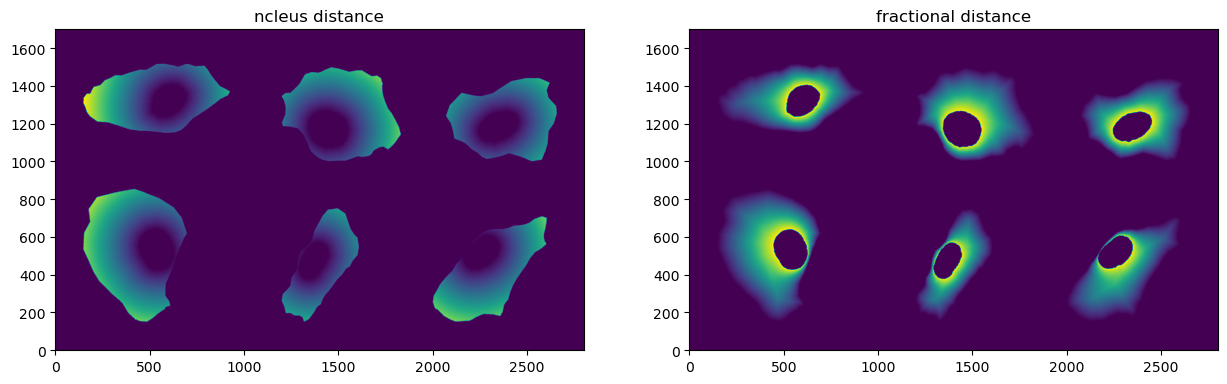

In [43]:
nucleus_distance = distance_transform_edt( ~nucleus_mask)*domains_mask/scale
border_distance = distance_transform_edt( cells_mask)*domains_mask/scale


fractional_distance = np.divide(border_distance,nucleus_distance+border_distance,out=np.zeros_like(border_distance),
            where=nucleus_distance+border_distance!=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns

axs[0].imshow(nucleus_distance,origin = "lower")
axs[0].set_title('ncleus distance')

axs[1].imshow(fractional_distance,origin = "lower")
axs[1].set_title('fractional distance')

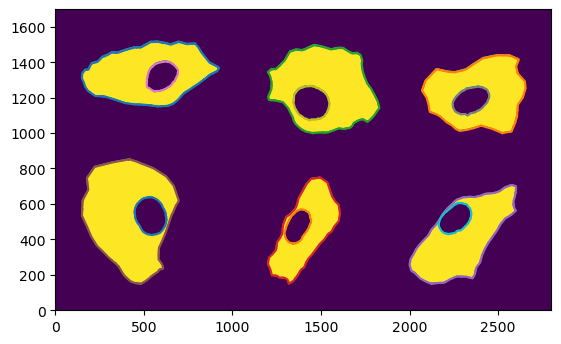

In [44]:
import cv2 as cv2
cell_contour_unordered, _ = cv2.findContours(cells_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
nucleus_contour_unordered, _ = cv2.findContours(nucleus_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in cell_contour_unordered:
    plt.plot(contour[:,0][:,0],contour[:,0][:,1])

for contour in nucleus_contour_unordered:
    plt.plot(contour[:,0][:,0],contour[:,0][:,1])
plt.imshow(domains_mask,origin = "lower")

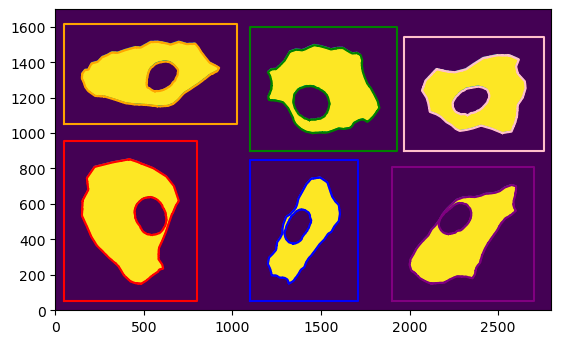

In [45]:
order_cell = np.array([5,0,2,3,1,4])
order_nuc =   np.array([4,0,2,5,1,3])

#plt.scatter(shift6["x"],shift6["y"])
#test_contour = cell_contour_unordered[4]
#plt.plot(test_contour[:,0][:,0],test_contour[:,0][:,1])


cell_contour = [cell_contour_unordered[i] for i in order_cell]
nucleus_contour = [nucleus_contour_unordered[i] for i in order_nuc]


for cc,nc,box,col in zip(cell_contour,nucleus_contour,boxes,colors):
    plt.plot(cc[:,0][:,0],cc[:,0][:,1],color =col)
    plt.plot(nc[:,0][:,0],nc[:,0][:,1],color =col)
    plt.plot(box[0],box[1],color =col)

plt.imshow(domains_mask,origin = "lower")


Text(0.5, 1.0, 'golgi')

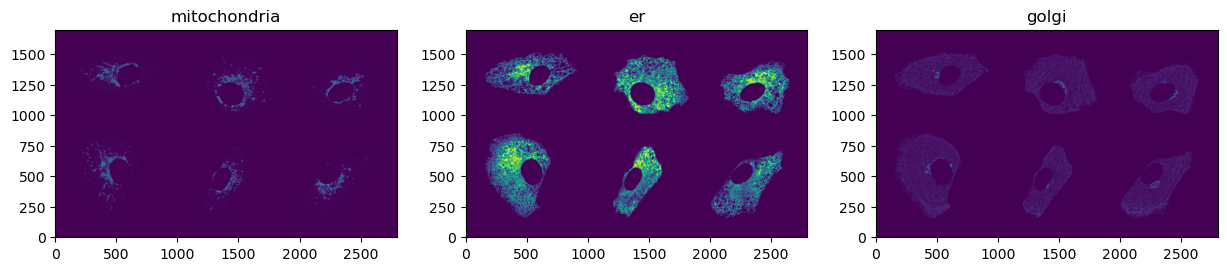

In [46]:
norm_mit = domains_mask*(mitochondria/np.mean(mitochondria[domains_mask]))

norm_er = domains_mask*(er/np.mean(er[domains_mask]))

norm_golgi = domains_mask*(golgi/np.mean(golgi[domains_mask]))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

axs[0].imshow(norm_mit,origin = "lower")
axs[0].set_title('mitochondria')

axs[1].imshow(norm_er,origin = "lower")
axs[1].set_title('er')

axs[2].imshow(norm_golgi,origin = "lower")
axs[2].set_title('golgi')

In [47]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

def get_blobs(image,min_sigma,max_sigma,threshold,ns):
    blobs_log = blob_log(image,min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=ns, threshold=threshold)
    return blobs_log[:,1] ,blobs_log[:,0] , np.sqrt(2)*blobs_log[:,2]


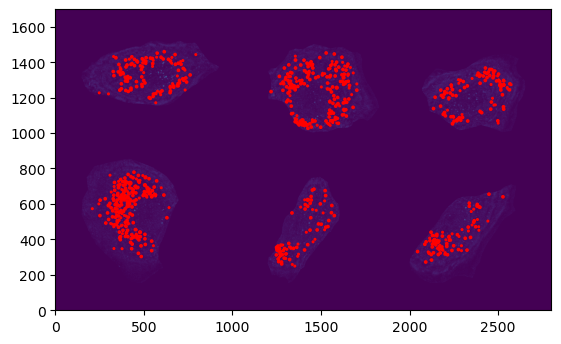

In [48]:
per_x, per_y, per_r = get_blobs(peroxisomes*1.0*domains_mask,1,40,40,40)
per_n = per_x.shape[0]

plt.imshow(peroxisomes,origin = "lower")
plt.scatter(per_x,per_y, s = per_r,color = "red")


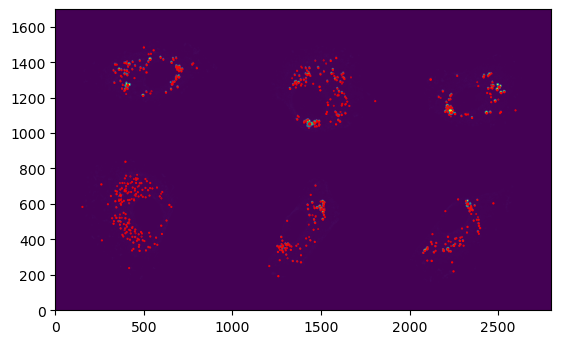

In [49]:
lip_x, lip_y, lip_r = get_blobs(lipid,1,40,40,40)

lip_n = lip_x.shape[0]
plt.imshow(lipid,origin = "lower")
plt.scatter(lip_x,lip_y, s = 0.1*lip_r,color = "red")



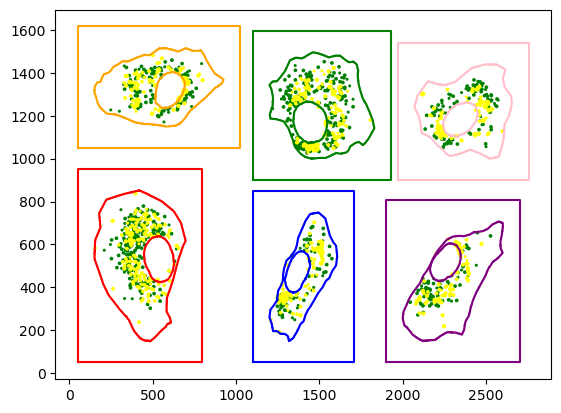

In [50]:

plt.scatter(per_x,per_y, s = per_r,color = "green")
plt.scatter(lip_x,lip_y, s = lip_r,color = "yellow")


for cc,nc,box,col in zip(cell_contour,nucleus_contour,boxes,colors):
    plt.plot(cc[:,0][:,0],cc[:,0][:,1],color =col)
    plt.plot(nc[:,0][:,0],nc[:,0][:,1],color =col)
    plt.plot(box[0],box[1],color =col)


RESCALE FROM PIXELS TO MICROMETERS

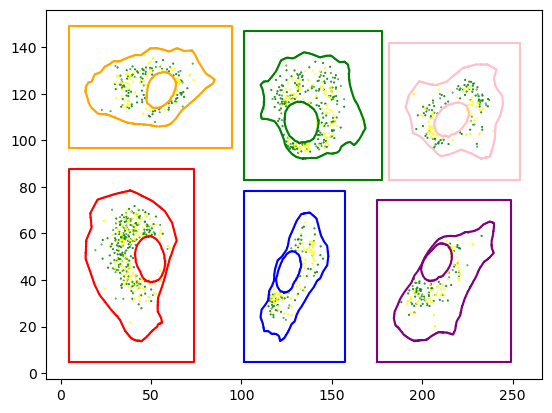

In [51]:
per_x_um, per_y_um, per_r_um = per_x/scale, per_y/scale, per_r/scale
lip_x_um, lip_y_um, lip_r_um = lip_x/scale, lip_y/scale, lip_r/scale

boxes_um = [ (np.array(box[0])/scale,np.array(box[1])/scale) for box in boxes] 

cell_contour_um = [cc/scale for cc in cell_contour]
nucleus_contour_um = [nc/scale for nc in nucleus_contour]

plt.scatter(per_x_um,per_y_um, s = per_r_um,color = "green")
plt.scatter(lip_x_um,lip_y_um, s = lip_r_um,color = "yellow")
for cc,nc,box,col in zip(cell_contour_um,nucleus_contour_um,boxes_um,colors):
    plt.plot(cc[:,0][:,0],cc[:,0][:,1],color =col)
    plt.plot(nc[:,0][:,0],nc[:,0][:,1],color =col)
    plt.plot(box[0],box[1],color =col)


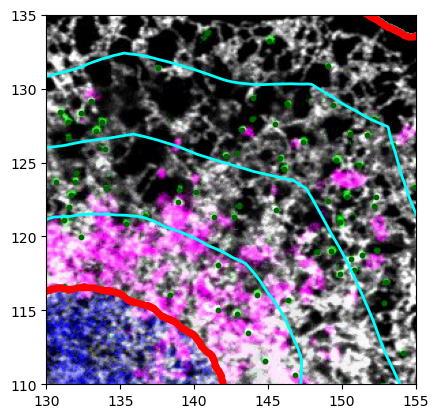

In [122]:
#plt.imshow(np.transpose(full_nice/np.max(full_nice), (1, 2, 0)),extent = (0,full_nice.shape[2]/scale,0,full_nice.shape[1]/scale),origin = "lower")
fig, ax = plt.subplots()

cax = plt.imshow(np.transpose(full_nice/np.max(full_nice), (1, 2, 0)),extent = (0,full_nice.shape[2]/scale,0,full_nice.shape[1]/scale),origin = "lower")

#cax = plt.imshow(fractional_distance,extent = (0,full_nice.shape[2]/scale,0,full_nice.shape[1]/scale),origin = "lower")

contour_levels = [0, 0.25, 0.5, 0.75, 1]

# Add contour lines
contours = ax.contour(fractional_distance, levels=contour_levels, colors='cyan', linewidths=2,extent = (0,full_nice.shape[2]/scale,0,full_nice.shape[1]/scale))

# Add contour labels
#ax.clabel(contours, inline=True, fontsize=8, fmt='%1.2f')



ax.scatter(per_x_um,per_y_um,s = 10,color = "darkgreen")
#plt.scatter(lip_x_um,lip_y_um, s = lip_r_um,color = "yellow")
for cc,nc,box,col in zip(cell_contour_um,nucleus_contour_um,boxes_um,colors):
    ax.plot(cc[:,0][:,0],cc[:,0][:,1],color ="red",linewidth=5)
    ax.plot(nc[:,0][:,0],nc[:,0][:,1],color = "red",linewidth=5)
#    plt.plot(box[0],box[1],color =col)

ax.plot([80,90],[40,40],color = "white")
plt.xlim([130,155])
plt.ylim([110,135])

plt.savefig("../../figures/VERO/data_covariates_zoomed.png",dpi =500)

In [23]:
import geopandas as gpd
from pyproj import CRS

per_data = {
    'id': np.arange(per_n).tolist(),
    'organelle': per_n*["peroxisome"],
    'r': per_r_um.tolist(),
    'x':  per_x_um.tolist(),
    'y': per_y_um.tolist() 
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(per_data, geometry=gpd.points_from_xy(per_data['x'], per_data['y']), crs=None)
# Save the GeoDataFrame as a GeoJSON file
gdf.to_file("geo/peroxisomes.geojson", driver="GeoJSON",crs=None)

lip_data = {
    'id': np.arange(lip_n).tolist(),
    'organelle': lip_n*["lipid droplet"],
    'r': lip_r_um.tolist(),
    'x':  lip_x_um.tolist(),
    'y': lip_y_um.tolist() 
}

# Create a GeoDataFrame
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(lip_data, geometry=gpd.points_from_xy(lip_data['x'], lip_data['y']), crs=None)
# Save the GeoDataFrame as a GeoJSON file
gdf.to_file("geo/lipid.geojson", driver="GeoJSON",crs=None)


In [24]:
import geopandas as gpd
from shapely.geometry import Polygon


domain_polygons = []
for cc,nc in zip(cell_contour_um,nucleus_contour_um):
    x_nuc = nc[:,0][:,0]
    y_nuc = nc[:,0][:,1]

    x_cell = cc[:,0][:,0]
    y_cell = cc[:,0][:,1]

    p1 = Polygon(zip(x_nuc, y_nuc))
    p2 = Polygon(zip(x_cell, y_cell))
    domain_polygons.append(Polygon(p2.exterior.coords, [p1.exterior.coords]))

# Create the main polygon with the hole

# Example DataFrame with a single polygon and an attribute field
data = {'ID': np.arange(1,7).tolist(), 'geometry': domain_polygons}
gdf_polygons = gpd.GeoDataFrame(data)  # Using WGS84 CRS as an example

# Save the GeoDataFrame as a GeoJSON file
gdf_polygons.to_file("geo/domain.geojson", driver="GeoJSON",crs=None)


In [25]:
# Create the polygon
box_polygons = [Polygon(zip(box[0],box[1])) for box in boxes_um ]

# Create a GeoDataFrame with the polygon
gdf = gpd.GeoDataFrame(geometry=box_polygons)

# Save the GeoDataFrame to a GeoJSON file
gdf.to_file("geo/meshbox.geojson", driver="GeoJSON",crs=None)


In [26]:
import rasterio
from rasterio.transform import from_origin

def save_rast(matrix,scale,name):
    matrix_f = np.flipud(matrix)
    
    resolution = 1/scale  # Resolution in micrometers (assuming square cells)
    
    # Calculate the transform matrix
    transform = from_origin(0, matrix.shape[0]/scale, resolution, resolution)
    
    # Specify the output file path
    output_file = "geo/" + name + ".tif"
    
    # Create a rasterio MemoryFile object to write the raster data
    with rasterio.open(output_file, 'w', driver='GTiff', height=matrix_f.shape[0], width=matrix_f.shape[1],
                       count=1, dtype=matrix_f.dtype, crs= None,
                       transform=transform) as dst:
        # Write the matrix data to the raster dataset
        dst.write(matrix_f, 1)


In [27]:
save_rast(norm_mit,scale,"mitochondria")
save_rast(norm_er,scale,"er")
save_rast(norm_golgi,scale,"golgi")

save_rast(nucleus_distance,scale,"nucleus_distance")
save_rast(fractional_distance,scale,"fractional_distance")


In [356]:
scale

10.8557